In [1]:
import sqlite3 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix 
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc 
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# Loading the Data and Sorting(Time-wise)

In [4]:
final_data = pd.read_csv("final.csv")

final_data = final_data.drop(["Text"], axis = 1)
final_data = final_data.drop(final_data.columns[0], axis = 1)
labels = final_data.Score
final_data = final_data.sort_values("Time")
final_data.shape

(364171, 10)

# Train/Test Split(70-30)

In [0]:
n = final_data.shape[0]
train_size = 0.7

train_set = final_data.iloc[:int(n*train_size)]
test_set =final_data.iloc[int(n*train_size):]

X_train = train_set.CleanedText
y_train = train_set.Score

X_test = test_set.CleanedText
y_test= test_set.Score

In [0]:
# Feature Importance(WordCloud Visualization)

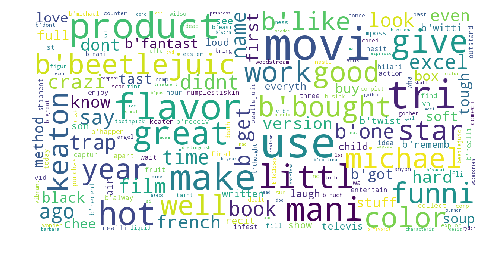

In [0]:
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(final_data["CleanedText"])

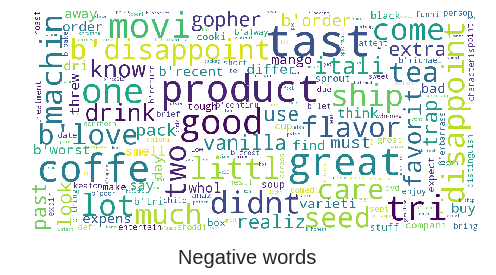

In [0]:
show_wordcloud(final_data[final_data.Score == "negative"]["CleanedText"], title = "Negative words")


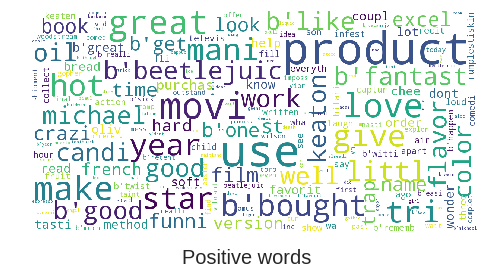

In [0]:
show_wordcloud(final_data[final_data.Score == "positive"]["CleanedText"], title = "Positive words")


# Bag of words Vectorization

In [0]:
count_vect = CountVectorizer() #in scikit-learn
X_train1 = count_vect.fit_transform(X_train)
X_test1 = count_vect.transform(X_test)

In [7]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



# Applying Naive Bayes


The optimal hyperparameter alpha is 10000.000000.


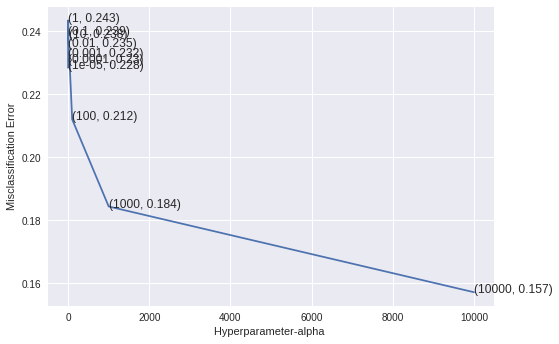

the misclassification error for each alpha value is :  [0.228 0.23  0.232 0.235 0.239 0.243 0.238 0.212 0.184 0.157]


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit
import pylab as pl

al = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

# empty list that will hold cv scores
cv_scores = []
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train1)]
# perform 10-fold cross validation
for a in al:
    knn = MultinomialNB(alpha=a)
    scores = cross_val_score(knn, X_train1, y_train, cv = my_cv, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_a = MSE.index(min(MSE))
n = al[optimal_a]
print('\nThe optimal hyperparameter alpha is %f.' % n)

# plot misclassification error vs alpha
plt.plot(al, MSE)

for xy in zip(al, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter-alpha ')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", (np.round(MSE,3)))

In [0]:
nb = MultinomialNB(alpha = 10000)
nb.fit(X_train1,y_train)
pred = nb.predict(X_test1)

# Generating Confusion matrix and Classification report

In [11]:

import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
x = nb.predict(X_train1)
tr_acc = accuracy_score(y_train, x, normalize=True) * float(100)
print('\n****Train accuracy is {:.2f}'.format(tr_acc))
print('\n****Test accuracy is {:.2f}'.format(acc))
print(confusion_matrix(y_test, pred))

print("")
target_names = ["positive", "negative"]
print(classification_report(y_test, pred, target_names=target_names))


****Train accuracy is 85.46

****Test accuracy is 82.46
[[  249 18832]
 [  326 89845]]

             precision    recall  f1-score   support

   positive       0.43      0.01      0.03     19081
   negative       0.83      1.00      0.90     90171

avg / total       0.76      0.82      0.75    109252



In [0]:
# Tf-idf Vectorization

In [0]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train2 = tf_idf_vect.fit_transform(X_train)
X_test2 = tf_idf_vect.transform(X_test)

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

# Applying Naive Bayes


The optimal hyperparameter alpha is 0.000010.


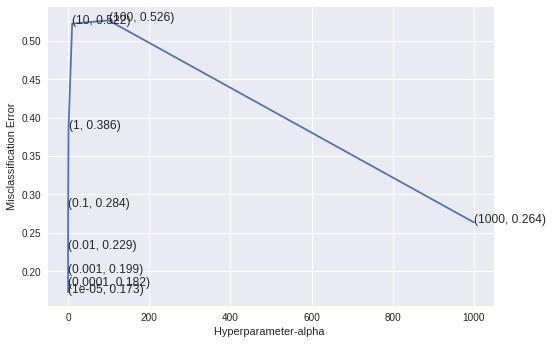

the misclassification error for each alpha value is :  [0.173 0.182 0.199 0.229 0.284 0.386 0.522 0.526 0.264]


In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit
import pylab as pl

al = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

# empty list that will hold cv scores
cv_scores = []
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train2)]
# perform 10-fold cross validation
for a in al:
    knn = MultinomialNB(alpha=a)
    scores = cross_val_score(knn, X_train2, y_train, cv = my_cv, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_a = MSE.index(min(MSE))
n = al[optimal_a]
print('\nThe optimal hyperparameter alpha is %f.' % n)

# plot misclassification error vs alpha
plt.plot(al, MSE)

for xy in zip(al, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter-alpha ')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", (np.round(MSE,3)))

In [0]:
nb = MultinomialNB(alpha = 0.00001)
nb.fit(X_train2,y_train)
pred = nb.predict(X_test2)


# Generating Confusion matrix and Classification report

In [0]:

import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
x = nb.predict(X_train2)
tr_acc = accuracy_score(y_train, x, normalize=True) * float(100)
print('\n****Train accuracy is {:.2f}'.format(tr_acc))
print('\n****Test accuracy is {:.2f}'.format(acc))
print(confusion_matrix(y_test, pred))

print("")
target_names = ["positive", "negative"]
print(classification_report(y_test, pred, target_names=target_names))


****Train accuracy is 99.79

****Test accuracy is 82.22
[[ 4264 14817]
 [ 4605 85566]]

             precision    recall  f1-score   support

   positive       0.48      0.22      0.31     19081
   negative       0.85      0.95      0.90     90171

avg / total       0.79      0.82      0.79    109252



# Conclusion

#### For 'Bag of Words'
- Train accuracy is 85.46%

- Test accuracy is 82.46%

## Confusion Matrix:
     [[  249 18832]
     [  326 89845]]

            

|      | Precision| recall | f1-score | support| 
|------|------||------||------||------|
|   positive | 0.43 |0.01|0.03 | 19081|
|   negative | 0.83 |1.00|0.90 | 90171|
|   avg/total | 0.76 |0.82|0.75 | 109252|

#### For 'Tf-idf'

- Train accuracy is 99.79%

-  Test accuracy is 82.22%

## Confusion Matrix:
      [[ 4264 14817]
      [ 4605 85566]]

         

|      | Precision| recall | f1-score | support| 
|------||------||------||------||------|
|   positive | 0.48 |0.22|0.31 | 19081|
|   negative | 0.85 |0.95|0.90 | 90171|
|   avg/total | 0.79 |0.82|0.79 | 109252|

## Important Words
### Positive :  
- 'product', 'use', 'great', 'movie' 

### Negative :
- 'product', disappoint', 'good', 'taste'